In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
import os
from p_mask_out_artifacts import mask_out_artifacts
from mountainlab_pytools import mdaio

import numpy as np

def test_mask_out_artifacts():
    
    # Create noisy array
    samplerate = int(48e3)
    duration = 30 # seconds
    n_samples = samplerate*duration
    noise_amplitude = 5
    noise = noise_amplitude*np.random.normal(0,1,n_samples)
    standard_dev = np.std(noise)
    
     # add three artefacts
    n_artifacts = 3
    artifacts = np.zeros_like(noise)
    artifact_duration = int(0.2*samplerate) # samples
    artifact_signal = np.zeros((n_artifacts, artifact_duration))

    for i in np.arange(n_artifacts):                   
        artifact_signal[i, :] = noise_amplitude*np.random.normal(0,6,artifact_duration)

    artifact_indices = np.tile(np.arange(artifact_duration), (3,1))

    artifact_shift = np.array([int(n_samples*0.10), int(n_samples*0.20), int(n_samples*0.70)])

    artifact_indices += artifact_shift.reshape((-1,1))

    for i, indices in enumerate(artifact_indices):
        artifacts[indices] = artifact_signal[i,:]

    signal = noise + artifacts

    timeseries = 'test_mask.mda'
    timeseries_out = 'masked.mda' 
    
    # write as mda
    mdaio.writemda32(signal.reshape((1,-1)), timeseries)
    
    # run the mask artefacts
    mask_out_artifacts(timeseries=timeseries, timeseries_out=timeseries_out, threshold=6, chunk_size=2000, 
                       num_write_chunks=150)
    
    # check that they are gone 
    read_data = mdaio.readmda(timeseries).reshape((-1,1))
    masked_data = mdaio.readmda(timeseries_out).reshape((-1,1))

    indices_masked = sum(masked_data[artifact_indices,0].flatten() == 0)
    total_indices_to_mask = len(artifact_indices.flatten())
    masked = indices_masked == total_indices_to_mask
    
    os.remove(timeseries)
    os.remove(timeseries_out)
    
    if masked:
        print('Artifacts 100% masked')
        return True
    else:
        print('Artifacts %.2f%% masked' % (100*(indices_masked/total_indices_to_mask)))
        return False

In [41]:
test_mask_out_artifacts()

For channel 0: mean=246.61, stdev=159.33, chunk size = 2000

Using 97.08% of all timepoints.

Artifacts 100% masked


True

(-150.0, 150.0)

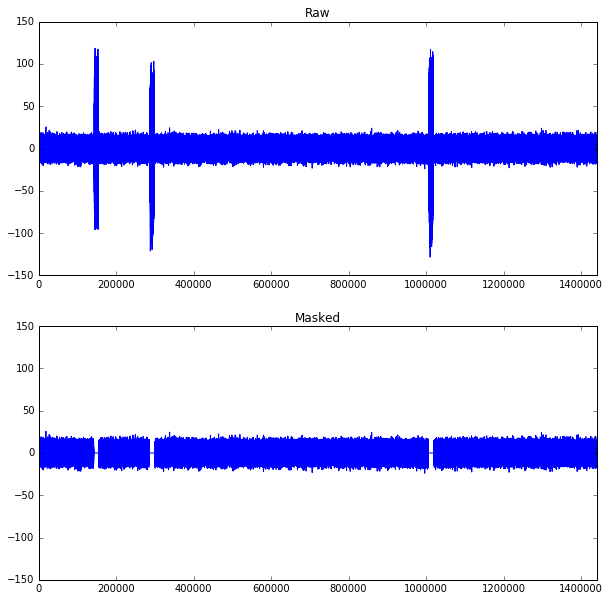

In [24]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
ax.plot(read_data)
ax.set_xlim(0,read_data.shape[0])
ax.set_title('Raw')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax = fig.add_subplot(212)
ax.plot(masked_data)
ax.set_title('Masked')
ax.set_xlim(xlim)
ax.set_ylim(ylim)